## EIP-1559 Simulations 

### References
* https://vitalik.ca/files/misc_files/EIP_1559_Fee_Structure.pdf
* https://github.com/gakonst/eip1559
* https://github.com/mtefagh/fee
* https://insights.deribit.com/market-research/analysis-of-eip-1559/
* https://github.com/gakonst/eip1559

In [37]:
from itertools import chain, repeat, cycle, islice
import datetime
import numpy as np
import matplotlib.pyplot as plt

In [38]:
# eth price
ETH = 240

BLOCKS_PER_MINUTE = 4  # assume 15 sec per block for convenience

# returns the USD required for a simple 21k gas transaction

def gas_to_usd(gas_price, eth_price):
    usd = gas_price * 21000 * eth_price * 1e-18
    return usd

# returns a seasonal series of low/high gas consumptions repeating `num_cycles`
# times


def generate_seasonal_data(low, high, low_reps, high_reps, num_cycles, start_with_high=True):
    # generate the iterators for each demand type
    low_demand_iter = repeat(low, low_reps)
    high_demand_iter = repeat(high, high_reps)

    # 1 cycle
    if start_with_high:
        data = cycle(chain(high_demand_iter, low_demand_iter))
    else:
        data = cycle(chain(low_demand_iter, high_demand_iter))

    # n cycles
    demand = islice(
        data,
        (low_reps + high_reps) * num_cycles
    )

    return demand


# EIP1559 constants
eip1559_constants = {
    "BASEFEE_MAX_CHANGE_DENOMINATOR": 50.0,
    #"TARGET_GAS_USED": 10000000.0,
    "TARGET_GAS_USED": 12500000.0,
    "EIP1559_DECAY_RANGE": 800000,
    "EIP1559_GAS_INCREMENT_AMOUNT": 10.0,
    "INITIAL_BASEFEE": float(1e10),
    "PER_TX_GASLIMIT": 8000000,
}
eip1559_constants["MAX_GAS_EIP1559"] = 2 * eip1559_constants["TARGET_GAS_USED"]

# runs the EIP1559 calculation in usd


def calculate_basefee(basefee, delta):
    new_basefee = basefee + basefee * delta / eip1559_constants["TARGET_GAS_USED"] / eip1559_constants["BASEFEE_MAX_CHANGE_DENOMINATOR"]
    # apply the clipping
    if new_basefee > 125 * basefee / 100:
        new_basefee = 125 * basefee / 100
    if new_basefee < 87.5 * basefee / 100:
        new_basefee = 87.5 * basefee / 100
    return new_basefee


def hours_to_blocks(duration):
    return duration * 60 * BLOCKS_PER_MINUTE  # blocks

def get_delta(demand):
    return map(
        lambda block_consumption:
        block_consumption - eip1559_constants["TARGET_GAS_USED"],
        demand
    )

In [3]:
def gen_gas_costs(deltas):

    basefee = eip1559_constants["INITIAL_BASEFEE"]
    gas_costs = np.zeros(len(deltas))
    basefees = np.zeros(len(deltas))
    for k in range(len(deltas)):
        new_basefee = calculate_basefee(basefee, deltas[k])
        basefee = new_basefee
        basefees[k] = basefee
        gas_costs[k] = gas_to_usd(basefee, ETH) 
        
    return basefees  

In [70]:
from scipy.signal import decimate
MINUTES_PER_YEAR = 525600

demands = np.random.normal(eip1559_constants['TARGET_GAS_USED'], 500000, 4*MINUTES_PER_YEAR)
deltas = list(get_delta(demands))
basefees = gen_gas_costs(deltas)
basefees = decimate(basefees, 240, ftype="fir")/1e9

sim = basefees.reshape(-1,1)

for k in range(1,10):
    demands = np.random.normal(eip1559_constants['TARGET_GAS_USED'], 500000, 4*MINUTES_PER_YEAR)
    deltas = list(get_delta(demands))
    basefees = gen_gas_costs(deltas)
    basefees = decimate(basefees, 240, ftype="fir")/1e9
    sim = np.hstack((sim,basefees.reshape(-1,1)))
    print(k, end='\r')

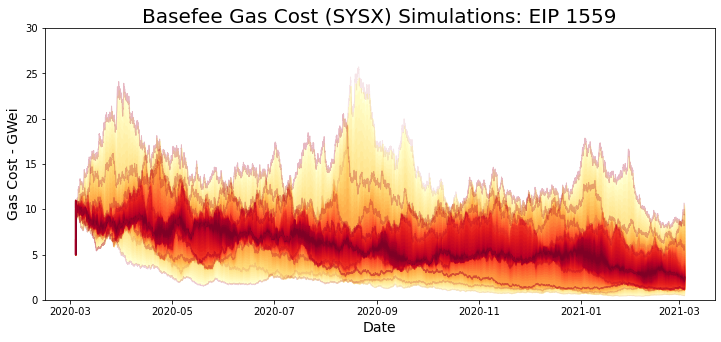

In [83]:
from pymc3.gp.util import plot_gp_dist
start = datetime.datetime(2020, 3, 4, 0, 0, 0)
date_times = np.array([start + datetime.timedelta(hours=i) for i in range(24*365)])
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
plot_gp_dist(ax, sim.transpose(), date_times, palette="YlOrRd")
plt.ylabel("Gas Cost - GWei", fontsize=14)
plt.xlabel("Date", fontsize=14)
plt.title("Basefee Gas Cost (SYSX) Simulations: EIP 1559", fontsize=20)
plt.ylim((0,30))
fig.savefig('../img/sysx_gas_costs_eip_1559.png')

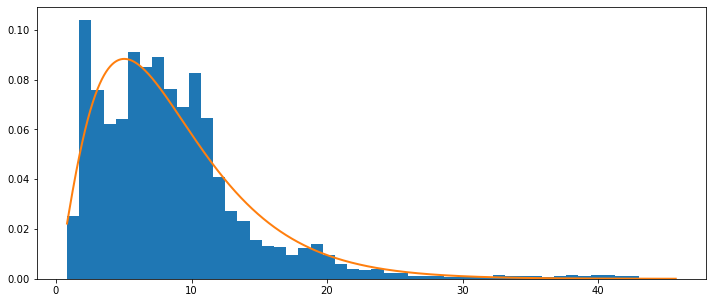

In [41]:
from pomegranate import *
basefees_sim = sim.flatten()
values = np.linspace(min(basefees_sim), max(basefees_sim), len(basefees_sim))
sample = basefees_sim.reshape(-1,1)
normal_model = GammaDistribution.from_samples(sample)
normal_fit = normal_model.probability(values.flatten())

fig = plt.figure(figsize=(12, 5))
plt.hist(sample, bins=50, density=True)
plt.plot(values, normal_fit, label="Gamma fit", linewidth=2)

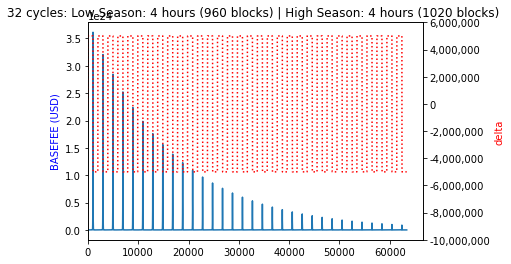

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import sys

eip1559_constants = {
    "BASEFEE_MAX_CHANGE_DENOMINATOR": 8.0,
    "TARGET_GAS_USED": 10000000.0,
    "EIP1559_DECAY_RANGE": 800000,
    "EIP1559_GAS_INCREMENT_AMOUNT": 10.0,
    "INITIAL_BASEFEE": float(1e9),
    "PER_TX_GASLIMIT": 8000000,
}
eip1559_constants["MAX_GAS_EIP1559"] = 2 * eip1559_constants["TARGET_GAS_USED"]

LOW_SEASON_DURATION = 4  # hours
NUM_CYCLES = 32  # number of cycles to observe
NUM_EXTRA_BLOCKS = 60

# high season lasts 1 hour more than low
HIGH_SEASON_DURATION = LOW_SEASON_DURATION

LOW_DEMAND = 5000000  # gas
HIGH_DEMAND = 15000000  # gas

#LOW_DEMAND = 10000000  # gas
#HIGH_DEMAND = 10000000  # gas

low_season_blocks = hours_to_blocks(LOW_SEASON_DURATION)
high_season_blocks = hours_to_blocks(HIGH_SEASON_DURATION) + NUM_EXTRA_BLOCKS

demand = generate_seasonal_data(
    LOW_DEMAND,
    HIGH_DEMAND,
    low_season_blocks,
    high_season_blocks,
    NUM_CYCLES
)

# the delta is the diff from the current value
deltas = get_delta(demand)

basefee = eip1559_constants["INITIAL_BASEFEE"]
rows = [{"basefee_usd": gas_to_usd(basefee, ETH), "delta": 0}]

# generate the data
for delta in deltas:
    new_basefee = calculate_basefee(basefee, delta)
    # update to the new value
    basefee = new_basefee
    rows += [{"basefee_usd": gas_to_usd(new_basefee, ETH), "delta": delta}]

# index = block number, cols = basefee, delta
df = pd.DataFrame(rows)

fig, ax = plt.subplots()
basefee_plot = ax.plot(df.basefee_usd)

ax.set_title(f"{NUM_CYCLES} cycles: \
Low Season: {LOW_SEASON_DURATION} hours ({low_season_blocks} blocks) | \
High Season: {HIGH_SEASON_DURATION} hours ({high_season_blocks} blocks) \
")
ax.set_ylabel("BASEFEE (USD)", color="blue")
ax.set_xlim(xmin=0)
# ax.set_yscale('log')

ax2 = ax.twinx()
delta_plot = ax2.plot(df.delta, color="red", ls="dotted")
ax2.set_ylabel("delta", color="red")
ax2.set_ylim([-10000000, 6000000])
ax2.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.show()